#Exercise Answer Key: Position Concentration Risk

## Lecture Link

This exercise notebook refers to this lecture. Please use the lecture for explanations and sample code.

https://www.quantopian.com/lectures#Position-Concentration-Risk

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import cvxpy

##Helper Functions

In [2]:
def get_markowitz_weights(mu, Sigma, gamma=1, max_position=1.0, max_leverage=1.0, short=False):
    w = cvxpy.Variable(len(Sigma))
    g = cvxpy.Parameter(sign='positive')
    L = cvxpy.Parameter()
    g.value = gamma
    L.value = max_leverage
    try:
        ret = mu.T*w
    except ValueError:
        ret = mu*w

    risk = cvxpy.quad_form(w, Sigma)

    objective = cvxpy.Maximize(ret - g*risk)
    constraints = [
        cvxpy.abs(w) < max_position,
        cvxpy.norm(w, 1) <= L, # Make it so we don't have to invest everything
    ]

    if not short:
        constraints.append(w >= 0) # Force all positive weights

    prob = cvxpy.Problem(
        objective,
        constraints
    )

    result = prob.solve()

    return w.value

#Exercise 1: Roulette Simulation

A roulette table has 38 pockets: 1 through 36, 0, and 00. A bet on an even number pays out at a ratio of 1:1. Landing on 0 and 00 count as losing.

You have $100 and are betting on an even number.

##a. All In

By running 1000 simulations, find the mean and standard deviation of the payout if you bet your entire $100 on one round.

In [3]:
universes = 1000
evens = 19
total = 38
payout = 100
rounds = 1
results = np.zeros(universes)

#Your code goes here

p = float(19)/total

for i in range(universes):
    results[i] = payout * np.random.binomial(n = rounds, p = p)

print("Payout mean:", np.mean(results))
print("Payout std:", np.std(results))

Payout mean: 49.4
Payout std: 49.99639987039067


##b. $1 Bets

By running 1000 simulations, find the mean and standard deviation of the payout if instead you bet $1 at a time and play 100 rounds.

In [4]:
universes = 1000
evens = 19
total = 38
payout = 1
rounds = 100
results = np.zeros(universes)

#Your code goes here

p = float(19)/total

for i in range(universes):
    results[i] = payout * np.random.binomial(n = rounds, p = p)

print("Payout mean:", np.mean(results))
print("Payout std:", np.std(results))

Payout mean: 49.938
Payout std: 5.0649931885442845


#Exercise 2: Portfolio Diversification

##a. Single Asset

Use the pricing data below to find the standard deviation of the returns of `AMZN` in the second half of the year 2015 and plot the price against time.

[*********************100%%**********************]  1 of 1 completed

AMZN returns std: 0.020463574624627952


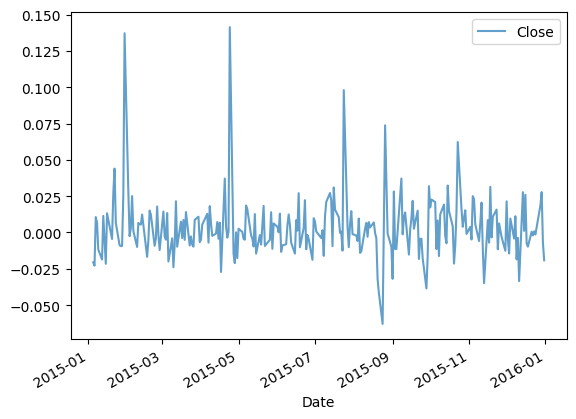

In [6]:
from datetime import datetime
import yfinance as yf

time_start = datetime(2015,1,1)
time_halfway = datetime(2015,7,1)
time_end = datetime(2016,1,1)
AMZN_r = yf.download('AMZN', start=time_start, end=time_end)['Close'].pct_change()[1:]
X = np.linspace(0, len(AMZN_r), len(AMZN_r))

#Your code goes here

print("AMZN returns std:", np.std(AMZN_r.loc[time_halfway:]))
AMZN_r.plot(alpha = 0.7);
plt.legend()


##b. Equally Weighted Portfolio

Create an equally weighted portfolio of the following 10 stocks, find the standard deviation of the portfolio's returns, and then plot the returns for the second half of 2015 along with the `AMZN` returns from above. Putting AMZN in a portfolio of 19 other securities should diversify the idiosyncratic risk and lower the price variability.

Hint: To calculate weighted returns dot the weight matrix `eweights_df` with the splice of the returns matrix containing the `symbol_list` pricing data (`returns_df[symbol_list]`).

[*********************100%%**********************]  20 of 20 completed
ERROR:yfinance:
6 Failed downloads:
ERROR:yfinance:['LB', 'BBT', 'SYMC', 'ATVI', 'CXO']: Exception('%ticker%: No timezone found, symbol may be delisted')
ERROR:yfinance:['MJN']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 00:00:00 -> 2016-01-01 00:00:00)')


AMZN returns std: 0.020463574624627952
Portfolio returns std: 0.014879503120202302


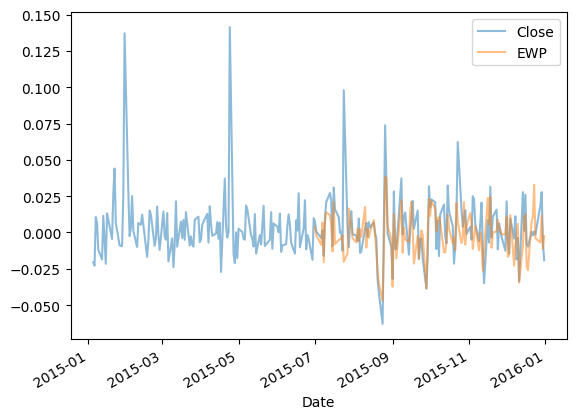

In [21]:
from datetime import datetime
import yfinance as yf

time_start = datetime(2015,1,1)
time_halfway = datetime(2015,7,1)
time_end = datetime(2016,1,1)

symbol_list = ['BEN', 'SYMC', 'IP', 'SWKS', 'IVZ', 'MJN', 'WMB', 'LB', 'TWX', 'NFX', 'PFE', 'LLY', 'HP', 'JPM', 'CXO', 'TJX', 'CAG', 'BBT', 'ATVI', 'NFLX']
prices_df = yf.download(symbol_list
                               , start=time_start, end=time_end)['Close']

prices_df.columns = [col for col in prices_df.columns]



returns_df = prices_df.pct_change(1)[1:]
returns_df = returns_df.dropna(axis=1, how='all')
dropped_columns = list(set(symbol_list) - set(returns_df.columns))
symbol_list = [symbol for symbol in symbol_list if symbol not in dropped_columns]
eweights_df = len(symbol_list) * [float(1)/len(symbol_list)]
returns_df['EWP'] = returns_df[symbol_list].dot(eweights_df)

print( "AMZN returns std:", np.std(AMZN_r.loc[time_halfway:]))
print( "Portfolio returns std:", np.std(returns_df['EWP'].loc[time_halfway:]))
AMZN_r.plot(alpha = 0.5);
returns_df['EWP'].loc[time_halfway:].plot(alpha=0.5);
plt.legend();

##c. Market Weighted Portfolio

Create a new portfolio of the same assets, this time weighted by market capitalization, find the standard deviation of the portfolio returns, and then plot the portfolio returns along with both results from above. Weighting using market capitalization brings us closer to the theoretical efficient portfolio, a portfolio of investments containing every single asset on the market, each weighted proportionately to its presence in the market.

The market cap is found using a pipeline factor, the steps for which are below.

In [ ]:
#Pipeline Setup
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import QTradableStocksUS
from time import time

universe = QTradableStocksUS()

pipe = Pipeline(columns = {'Market Cap' : morningstar.valuation.market_cap.latest},
    screen=universe
)

start_timer = time()
results = run_pipeline(pipe, time_start, time_end)
end_timer = time()
results.fillna(value=0);

print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

# This is important as sometimes the first data returned won't be on the specified start date
first_trading_day = results.index.levels[0][1]

market_cap = results.loc[first_trading_day]['Market Cap']

market_cap.index = [x.symbol for x in market_cap.index]#pd.MultiIndex.from_tuples([(x[0], x[1].symbol) for x in market_cap.index])

mcs = market_cap # pd.DataFrame(market_cap.loc[(first_trading_day,)].loc[symbol_list]).transpose()

In [ ]:
mweights = (mcs[symbol_list]/sum(mcs[symbol_list])).transpose()

#Your code goes here

##d. Markowitz Portfolio

Create a new portfolio of the same assets, this time using the `get_markowitz_weights` helper function to create the Markowitz mean-variance portfolio. Use the pricing data from the first half of 2015 to calibrate the weights, and then plot the portfolio returns for the second half of 2015.

### Important Note

If the weights from the lookback window (6 prior months), are correlated with the weights of the forward window (6 following months), then this optimization should be helpful in reducing out portfolio volatility going forward. However, this is often not the case in real life. Real markets are complicated, and historical volatility may not be a good predictor of future volatility. Volatility forecasting models are an entire area of research in finance, so don't think that just because historic volatility of your portfolio was low, it will be equally low in the future. This is just one technique that attempts to control portfolio risk, there is a more complete discussion of this in this lecture:

https://www.quantopian.com/lectures/risk-constrained-portfolio-optimization

In [ ]:
mu = returns_df[symbol_list].\
        loc[:time_halfway].fillna(0).mean().as_matrix()
sigma = returns_df[symbol_list].\
        loc[:time_halfway].fillna(0).cov().as_matrix()

mkweights_df = get_markowitz_weights(mu, sigma)

#Your code goes here

Although the Markowitz portfolio was supposed to produce the portfolio with the least variance for the given returns, it failed to do so in this out-of-sample scenario.

As discussed above, covariance matrices are volatile and tend to shift rapidly. When we calibrated the Markowitz weights we used the covariance matrix from the first half of 2015 as our sample and ran it through the second half of 2016, meaning our test was out-of-sample. Due to the volatile nature of covariance matrices, it is likely that the covariance matrix had significantly changed between the sample and out-of-sample time periods, making our Markowitz weights invalid for the out-of-sample period.

---

Congratulations on completing the Position Concentration Risk exercises!

As you learn more about writing trading algorithms and the Quantopian platform, be sure to check out the daily [Quantopian Contest](https://www.quantopian.com/contest), in which you can compete for a cash prize every day.

Start by going through the [Writing a Contest Algorithm](https://www.quantopian.com/tutorials/contest) tutorial.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solic
itation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*